# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [2]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as st
import sklearn
from sklearn.datasets import load_boston
from tqdm import tqdm

In [46]:
from sklearn.datasets import load_boston

# to see the information of the variables
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [11]:
# read the data
boston_df = pd.read_csv("../data/boston_data.csv")

# checking the df
print(boston_df.isnull().sum())
round(boston_df.describe(), 2)

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,3.73,10.51,11.19,0.07,0.56,6.30,68.60,3.80,9.84,411.69,18.44,355.07,12.60,22.31
std,8.94,22.05,6.81,0.25,0.12,0.68,28.07,2.11,8.83,171.07,2.15,94.49,6.93,8.84
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.17,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.90,45.80,2.09,4.00,281.00,17.38,374.71,7.14,17.10
50%,0.25,0.00,9.80,0.00,0.54,6.23,76.60,3.21,5.00,330.00,19.00,391.06,11.26,21.40
75%,4.05,12.50,18.10,0.00,0.63,6.63,94.15,5.22,24.00,666.00,20.20,396.01,16.91,25.00
max,88.98,95.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,34.37,50.00


In [52]:
# (c) duarteharris

# removing outliers
# check for outliers percentage in each column based on IQR
for col in boston_df.columns[1:]:
    Q1 = boston_df[col].quantile(0.25)
    Q3 = boston_df[col].quantile(0.75)
    IQR = Q3 - Q1 
    n_outliers = len([i for i in boston_df[col] 
                      if (i < Q1 - 1.5 * IQR) | (i > Q3 + 1.5 * IQR)])
    
    print(col, round(n_outliers / len(boston_df) * 100, 2),"%")

#remove outliers based on z score above 3 == values beyond 3 std.dev from the mean both sides.
boston_clean  = boston_df[(np.abs(st.zscore(boston_df.loc[:, boston_df.columns != "chas"])) 
                                 < 3).all(axis = 1)]

# checking that there was no interference with the bool values in chas
boston_clean[boston_clean["chas"] == 1]

# cheking how many values where droped
len(boston_df) - len(boston_clean)

zn 12.13 %
indus 0.0 %
chas 6.93 %
nox 0.0 %
rm 5.2 %
age 0.0 %
dis 1.24 %
rad 0.0 %
tax 0.0 %
ptratio 2.97 %
black 15.1 %
lstat 0.5 %
medv 6.68 %


60

### Next, we want to explore the data. Pick several variables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [20]:
corr_matrix = boston_clean.corr()

round(corr_matrix, 2)

# lstat has a reasonable high negative correlation with medv
# and rm also has a reasonable high (positive) correlation with medv, so they're probably the best to plot?

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.00,-0.24,0.52,-0.06,0.54,-0.20,0.43,-0.48,0.81,0.75,0.34,-0.32,0.55,-0.50
zn,-0.24,1.00,-0.47,-0.04,-0.44,0.31,-0.46,0.56,-0.24,-0.27,-0.32,0.15,-0.37,0.35
indus,0.52,-0.47,1.00,0.04,0.73,-0.37,0.56,-0.66,0.56,0.70,0.29,-0.33,0.60,-0.57
chas,-0.06,-0.04,0.04,1.00,0.11,-0.00,0.08,-0.09,-0.04,-0.07,-0.14,-0.03,0.03,0.05
nox,0.54,-0.44,0.73,0.11,1.00,-0.29,0.69,-0.75,0.55,0.63,0.06,-0.37,0.57,-0.48
rm,-0.20,0.31,-0.37,-0.00,-0.29,1.00,-0.20,0.20,-0.11,-0.21,-0.20,0.11,-0.62,0.72
age,0.43,-0.46,0.56,0.08,0.69,-0.20,1.00,-0.70,0.40,0.46,0.17,-0.23,0.60,-0.46
dis,-0.48,0.56,-0.66,-0.09,-0.75,0.20,-0.70,1.00,-0.44,-0.51,-0.15,0.27,-0.49,0.32
rad,0.81,-0.24,0.56,-0.04,0.55,-0.11,0.40,-0.44,1.00,0.90,0.43,-0.30,0.44,-0.42
tax,0.75,-0.27,0.70,-0.07,0.63,-0.21,0.46,-0.51,0.90,1.00,0.42,-0.33,0.51,-0.54


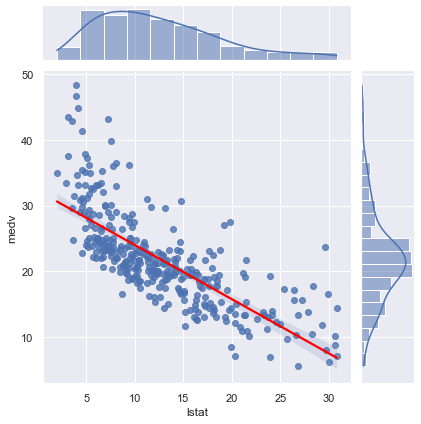

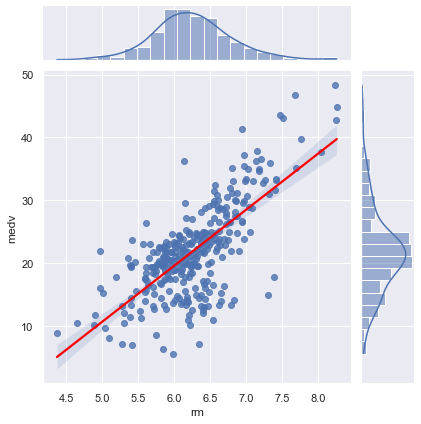

In [53]:
# creating plots that show the data dispersion as well as the regression line of best fit for
# each column
for col in boston_clean[["lstat", "rm"]]:
    scat = sns.jointplot(x = col, y = "medv", data = boston_clean, kind = "reg")
    line = scat.ax_joint.get_lines()[0]
    line.set_color("red")

    plt.show()

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [ ]:
# the relationship is negative
# and yes we expected it from seeing their correlation
# which maybe cheating as the question is to pick it before analysing it.. but it is what it is

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

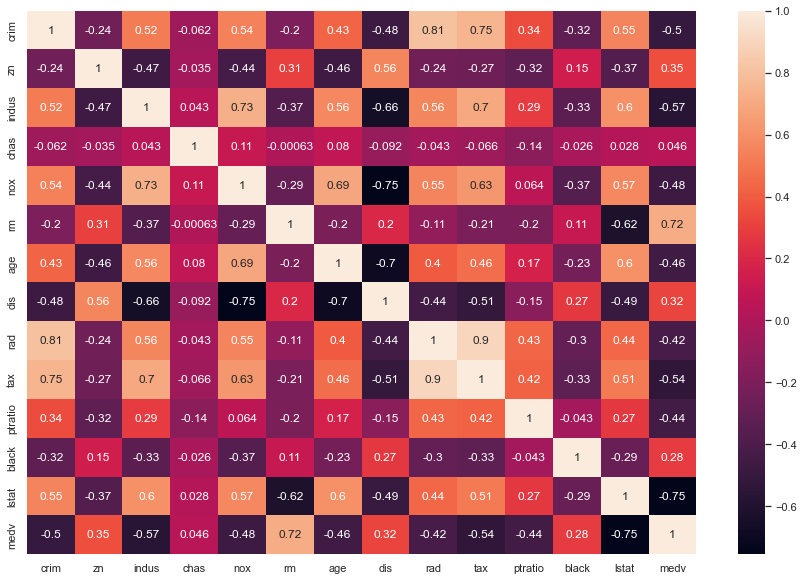

In [30]:
plt.subplots(figsize= (15,10))
sns.heatmap(corr_matrix, annot= True)
plt.show()

In [ ]:
## all of them are not highly correlated but it is > 0.50
# negative correlation:
# nox - dis
# indus - dis
# age - dis

# positive correlation:
# crim - dis
# nox - lstat
# indus - age

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [54]:
round(boston_df["medv"].describe(), 2)

count    404.00
mean      22.31
std        8.84
min        5.00
25%       17.10
50%       21.40
75%       25.00
max       50.00
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [31]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [32]:
from sklearn.model_selection import train_test_split

y = boston_df["medv"]
X = boston_df.drop(labels = "medv", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [33]:
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor

# defining each depth to try
depths = [2, 4, 6, 8, 10]

# initializing lists to keep the scores
train_scores = list()
test_scores = list()

# testing
for d in depths:
    # initializing model
    rfr = RandomForestRegressor(max_depth = d)
    
    # fiting
    rfr.fit(X_train, y_train)
    
    # predicting train
    y_pred_train = rfr.predict(X_train)
    
    # predicting test
    y_pred_test = rfr.predict(X_test)
    
    # Scoring the tests
    train_score = performance_metric(y_train, y_pred_train)
    test_score = performance_metric(y_test, y_pred_test)

    train_scores += [train_score]
    test_scores += [test_score]

In [55]:
print(train_scores)
print(test_scores)

[0.7818127229495014, 0.9230628294527301, 0.9568227018844147, 0.9740049999548684, 0.9763521580653097]
[0.6086265968227428, 0.6770657619614138, 0.7093526366355585, 0.7234446637937109, 0.7554820954612179]


Now, plot the score for each tree on the training set and on the testing set.

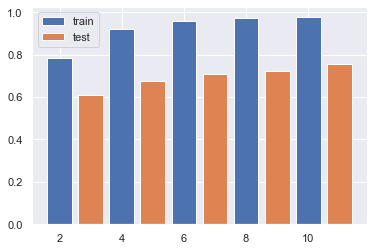

In [39]:
# Produce a plot with the score for the testing and training for the different max depths

# plotting train scores
plt.bar(x = depths, height = train_scores, label = "train")

# ploting test scores
plt.bar(x = [d + 1 for d in depths], height = test_scores, label = "test")

# generating legend
plt.legend()
plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# After (including) a depth of 6, the gains are marginal at best 
# (and if you look at the numbers, you actually lose points).

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [56]:
# (c) duarteharris

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer 
from sklearn.model_selection import GridSearchCV, ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], test_size = 0.20, random_state = 0)
    print (cv_sets)
    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {"max_depth": range(1, 11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, 
                        cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [57]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print(f"\nParameter 'max_depth' is {reg.get_params()['max_depth']} for the optimal model.")

ShuffleSplit(n_splits=323, random_state=0, test_size=0.2, train_size=None)

Parameter 'max_depth' is 5 for the optimal model.


### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here